In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

dogs-vs-cats-redux-kernels-edition
keras-models



In [2]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.utils import shuffle
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense



In [5]:
batch_size = 32

data_root_dir = '../input/dogs-vs-cats-redux-kernels-edition/'

keras_models_dir = '../input/keras-models/'

print(check_output(["ls", keras_models_dir]).decode("utf8"))
print(check_output(["ls", data_root_dir]).decode("utf8"))

imagenet_class_index.json
images
vgg16_weights_tf_dim_ordering_tf_kernels_0.h5
vgg16_weights_tf_dim_ordering_tf_kernels_1.h5
vgg16_weights_tf_dim_ordering_tf_kernels_2.h5
vgg16_weights_tf_dim_ordering_tf_kernels_3.h5
vgg16_weights_tf_dim_ordering_tf_kernels_4.h5
vgg16_weights_tf_dim_ordering_tf_kernels_5.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg19_weights_tf_dim_ordering_tf_kernels_0.h5
vgg19_weights_tf_dim_ordering_tf_kernels_1.h5
vgg19_weights_tf_dim_ordering_tf_kernels_2.h5
vgg19_weights_tf_dim_ordering_tf_kernels_3.h5
vgg19_weights_tf_dim_ordering_tf_kernels_4.h5
vgg19_weights_tf_dim_ordering_tf_kernels_5.h5
vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5

test
train



In [6]:
img_width, img_height = 224, 224

vgg16 = applications.VGG16(include_top=False, weights=None) #input_shape = (3, img_width, img_height)

def load_split_weights(model, model_path_pattern='model_%d.h5', memb_size=102400000):  
    model_f = h5py.File(model_path_pattern, "r", driver="family", memb_size=memb_size)
    topology.load_weights_from_hdf5_group_by_name(model_f, model.layers)
    return model

model_path_pattern = keras_models_dir + "vgg16_weights_tf_dim_ordering_tf_kernels_%d.h5" 
vgg16 = load_split_weights(vgg16, model_path_pattern = model_path_pattern)

# set the first 25 layers (up to the last conv block) to non-trainable (weights will not be updated)
for layer in vgg16.layers[:25]:
    layer.trainable = False

x = vgg16.get_layer('block5_conv3').output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg16.input, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
def augment(src, choice):
    if choice == 0:
        # Rotate 90
        src = np.rot90(src, 1)
    if choice == 1:
        # flip vertically
        src = np.flipud(src)
    if choice == 2:
        # Rotate 180
        src = np.rot90(src, 2)
    if choice == 3:
        # flip horizontally
        src = np.fliplr(src)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = np.rot90(src, 3)
    if choice == 5:
        # Rotate 180 and flip horizontally
        src = np.rot90(src, 2)
        src = np.fliplr(src)
    return src

In [9]:
import glob
from sklearn.cross_validation import train_test_split
from numpy import random

train_dogs = glob.glob(data_root_dir + "train/dog.*")
train_cats = glob.glob(data_root_dir + "train/cat.*")
#print (train_cats[:1])

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
images = train_dogs[:1200] + train_cats[:1200]
random.shuffle(images)

#print(images[:2])
labels = []
for i in images:
    #print(i)
    if "dog." in i:
        labels.append(1)
    else:
        labels.append(0)
        
batch_size = 10

def process_img(i):
    img = load_img(dogs[i])  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    #x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    return x;

train_images, validation_images = train_test_split(images, test_size=0.4)

#print("Train shape: {}".format(train.shape))
#print("Test shape: {}".format(test.shape))
#print("Validation shape: {}".format(valid.shape))
#print(len(train_images))
print(train_images[:1])
print(validation_images[:1])

['../input/dogs-vs-cats-redux-kernels-edition/train/dog.5172.jpg']
['../input/dogs-vs-cats-redux-kernels-edition/train/dog.6416.jpg']


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


http://sujitpal.blogspot.com.au/2017/02/using-keras-imagedatagenerator-with.html

In [10]:
import matplotlib.pyplot as plt
from scipy.misc import imresize

def imread(image_path):
    image = plt.imread(image_path)
    image = imresize(image, (img_width, img_height))
    return image

def preprocess_images(image_names, seed, datagen):
    #print (image_names)
    np.random.seed(seed)
    X = np.zeros((len(image_names), img_width, img_height, 3))
    for i, image_name in enumerate(image_names):
        #print (image_name)
        image = imread(image_name)
        X[i] = datagen.random_transform(image)
    return X

def image_triple_generator(train_images, batch_size):
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
    datagen = ImageDataGenerator(**datagen_args)
    
    while True:
        # loop once per epoch
        num_recs = len(train_images)
        #print(num_recs)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            #print(batch_indices)
            batch = [train_images[i] for i in batch_indices]
            #print(batch)
            # make sure image data generators generate same transformations
            seed = np.random.randint(low=0, high=1000, size=1)[0]
            batch_label = []
            batch_img = preprocess_images(batch, seed, datagen)
            for i in batch:
                if "dog." in i:
                    batch_label.append(1)
                else:
                    batch_label.append(0)
                    
            yield batch_img, batch_label
            
batches = image_triple_generator(train_images, 4)
val_batches = image_triple_generator(validation_images, 4)

In [11]:
trn_classes = len(train_images)
val_classes = len(validation_images)
steps_per_epoch=int(np.ceil(trn_classes/batch_size))
validation_steps=int(np.ceil(val_classes/batch_size))    
epochs=15

print ("epochs:" + str(epochs))
print ("batch_size:" + str(batch_size))
print ("trn_classes:" + str(trn_classes))
print ("val_classes:" + str(val_classes))
print ("steps_per_epoch:" + str(steps_per_epoch))
print ("validation_steps:" + str(validation_steps))

epochs:15
batch_size:10
trn_classes:1440
val_classes:960
steps_per_epoch:144
validation_steps:96


In [12]:
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import LearningRateScheduler
import os.path

fine_weights_path = 'tune_weights.h5'

if os.path.isfile(fine_weights_path) :
    print ("load fine_weights_path:" + fine_weights_path)
    model.load_weights(fine_weights_path)
    
def step_decay(epoch):
    if epoch >= 0 and epoch < 2:
        lrate = 0.0001 #Default Adam lr=0.001
    elif epoch >= 2 and epoch < 5:
        lrate = 0.00001
    elif epoch >= 5 and epoch < 10:
        lrate = 0.000001
    elif epoch >= 15 and epoch < 20:
        lrate = 0.0000001
    else:
        lrate = 0.0000001
    
    print (str(epoch) + " learning rate:%.6f" % lrate)
    return lrate

reduce_lr = LearningRateScheduler(step_decay)

callbacks_list = [
    ModelCheckpoint(fine_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=1),reduce_lr]

In [13]:
history = model.fit_generator(batches, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=val_batches, 
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,          
                    verbose=1)

Epoch 1/15
0 learning rate:0.000100


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


144/144 [==============================] - 27s 189ms/step - loss: 1.0161 - acc: 0.6510 - val_loss: 0.2904 - val_acc: 0.8906

Epoch 00001: val_acc improved from -inf to 0.89062, saving model to tune_weights.h5
Epoch 2/15
1 learning rate:0.000100
144/144 [==============================] - 25s 175ms/step - loss: 0.4893 - acc: 0.8229 - val_loss: 0.2489 - val_acc: 0.8984

Epoch 00002: val_acc improved from 0.89062 to 0.89844, saving model to tune_weights.h5
Epoch 3/15
2 learning rate:0.000010
144/144 [==============================] - 25s 173ms/step - loss: 0.4112 - acc: 0.8316 - val_loss: 0.2650 - val_acc: 0.8932

Epoch 00003: val_acc did not improve
Epoch 4/15
3 learning rate:0.000010
144/144 [==============================] - 25s 171ms/step - loss: 0.4494 - acc: 0.8125 - val_loss: 0.2090 - val_acc: 0.9141

Epoch 00004: val_acc improved from 0.89844 to 0.91406, saving model to tune_weights.h5
Epoch 5/15
4 learning rate:0.000010
144/144 [==============================] - 25s 171ms/step - l

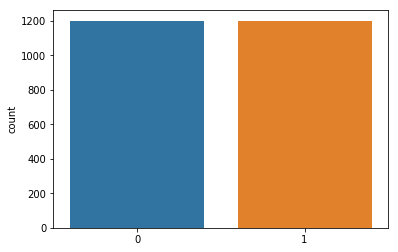

In [14]:
import seaborn

seaborn.countplot(labels)
#seaborn.plt.title('Cats and Dogs')

In [15]:
 print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*history.history['acc'][-1], 100*history.history['val_acc'][-1]))

Training accuracy: 87.85% / Validation accuracy: 90.89%


In [17]:
model.save_weights(fine_weights_path)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


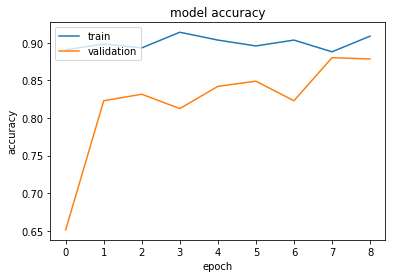

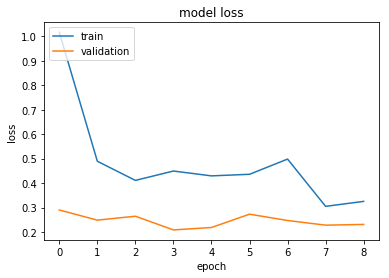

In [18]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()